In [13]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm

In [14]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())


2.6.0+cu126
True


In [15]:
# ================================================================
# CONFIG
# ================================================================

REDDIT_CSV = "reddit_df.csv"

MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
OUTPUT_DETAILED = "sentiment_detailed.csv"
OUTPUT_DAILY = "sentiment_daily.csv"
AGG_FREQ = "D"   # D = diario, H = horario


# ================================================================
# LOAD DATASET
# ================================================================

def load_reddit_dataset(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce", utc=True)
    df = df.dropna(subset=["datetime", "comment"])

    df = df.rename(columns={
        "datetime": "timestamp",
        "comment": "text"
    })

    df["source"] = "reddit_comments"
    return df[["timestamp", "text", "source"]]


# ================================================================
# SENTIMENT MODEL
# ================================================================

def load_sentiment_model(model_name: str):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    nlp = pipeline(
        "sentiment-analysis",
        model=model,
        tokenizer=tokenizer,
        truncation=True,
        max_length=256
    )
    return nlp, model.config.id2label


def label_to_score(label: str) -> float:
    label = label.upper()
    if "NEG" in label:
        return -1.0
    if "NEU" in label:
        return 0.0
    if "POS" in label:
        return 1.0
    return 0.0


# ================================================================
# SENTIMENT PIPELINE
# ================================================================

def compute_sentiment(df: pd.DataFrame, nlp) -> pd.DataFrame:
    tqdm.pandas(desc="Sentiment analysis")

    def analyze(text):
        return nlp(str(text)[:512])[0]

    results = df["text"].progress_apply(analyze)

    df["sent_label"] = results.apply(lambda x: x["label"])
    df["sent_score_raw"] = results.apply(lambda x: x["score"])
    df["sent_score"] = df["sent_label"].map(label_to_score)
    df["sent_score_weighted"] = df["sent_score"] * df["sent_score_raw"]

    return df


def aggregate_daily(df: pd.DataFrame, freq="D") -> pd.DataFrame:
    df = df.set_index("timestamp")

    agg = df.resample(freq).agg({
        "sent_score": "mean",
        "sent_score_weighted": "mean",
        "text": "count"
    })

    agg = agg.rename(columns={
        "sent_score": "sentiment_mean",
        "sent_score_weighted": "sentiment_weighted_mean",
        "text": "num_texts"
    })

    agg = agg.dropna(how="all").reset_index()
    return agg


# ================================================================
# MAIN
# ================================================================

def main():
    print("[INFO] Loading dataset...")

    df = load_reddit_dataset(REDDIT_CSV)
    df = df.sort_values("timestamp")

    print(f"[INFO] Total rows: {len(df)}")

    print("[INFO] Loading sentiment model...")
    nlp, labels = load_sentiment_model(MODEL_NAME)
    print(f"[INFO] Model labels: {labels}")

    print("[INFO] Running sentiment analysis...")
    df_sent = compute_sentiment(df, nlp)

    print(f"[INFO] Saving detailed dataset to {OUTPUT_DETAILED}")
    df_sent.to_csv(OUTPUT_DETAILED, index=False)

    print("[INFO] Aggregating daily sentiment...")
    df_daily = aggregate_daily(df_sent, AGG_FREQ)

    print(f"[INFO] Saving daily sentiment to {OUTPUT_DAILY}")
    df_daily.to_csv(OUTPUT_DAILY, index=False)

    print("[INFO] Done.")

In [16]:
if __name__ == "__main__":
    main()

[INFO] Loading dataset...
[INFO] Total rows: 1893
[INFO] Loading sentiment model...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


[INFO] Model labels: {0: 'negative', 1: 'neutral', 2: 'positive'}
[INFO] Running sentiment analysis...


Sentiment analysis: 100%|██████████| 1893/1893 [00:39<00:00, 47.64it/s]

[INFO] Saving detailed dataset to sentiment_detailed.csv
[INFO] Aggregating daily sentiment...
[INFO] Saving daily sentiment to sentiment_daily.csv
[INFO] Done.


In [17]:
import pandas as pd

df = pd.read_csv("sentiment_detailed.csv", parse_dates=["timestamp"])

print(df.head())
print(df.sent_label.value_counts())


                  timestamp  \
0 2022-12-08 13:59:26+00:00   
1 2022-12-08 14:15:19+00:00   
2 2022-12-08 14:33:26+00:00   
3 2022-12-08 14:59:15+00:00   
4 2022-12-08 15:08:58+00:00   

                                                text           source  \
0  messing up at robosats hi everyone i tried out...  reddit_comments   
1  coinbase transaction if anyone can please clar...  reddit_comments   
2  desire to sell i just realized this dip in bit...  reddit_comments   
3  slp federico tenga what is rgb for bitcoin iri...  reddit_comments   
4  billion of btc has left exchanges this month t...  reddit_comments   

  sent_label  sent_score_raw  sent_score  sent_score_weighted  
0   positive        0.451700         1.0             0.451700  
1    neutral        0.872928         0.0             0.000000  
2   positive        0.750223         1.0             0.750223  
3    neutral        0.911581         0.0             0.000000  
4    neutral        0.526235         0.0             0

In [18]:
conteo = df["sent_label"].value_counts()
print("Conteo de sentimientos:")
print(conteo)


Conteo de sentimientos:
sent_label
neutral     1081
negative     576
positive     236
Name: count, dtype: int64


In [19]:
agrupado = df.groupby("sent_label")[["sent_score", "sent_score_raw", "sent_score_weighted"]].mean()
print("Promedios por sentimiento:")
print(agrupado)


Promedios por sentimiento:
            sent_score  sent_score_raw  sent_score_weighted
sent_label                                                 
negative          -1.0        0.712287            -0.712287
neutral            0.0        0.710097             0.000000
positive           1.0        0.755666             0.755666


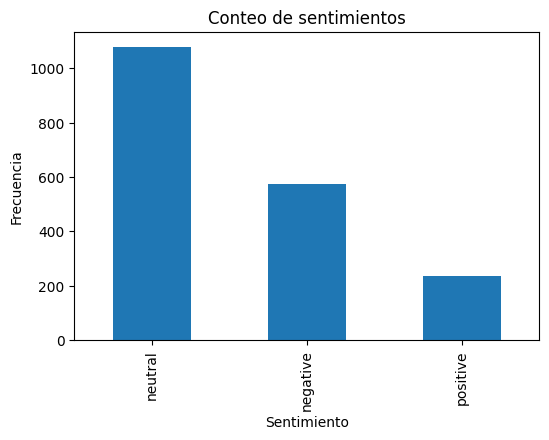

In [20]:
import matplotlib.pyplot as plt

df["sent_label"].value_counts().plot(kind="bar", figsize=(6,4))
plt.title("Conteo de sentimientos")
plt.xlabel("Sentimiento")
plt.ylabel("Frecuencia")
plt.show()


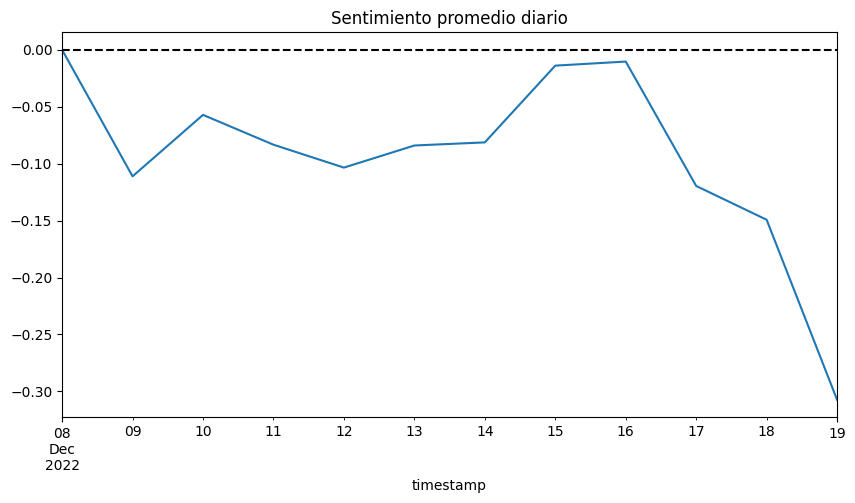

In [21]:
df_daily = pd.read_csv("sentiment_daily.csv", parse_dates=["timestamp"])
df_daily.set_index("timestamp", inplace=True)

df_daily["sentiment_mean"].plot(figsize=(10,5))
plt.title("Sentimiento promedio diario")
plt.axhline(0, color="black", linestyle="--")
plt.show()


In [22]:
# Agregar número de textos por día y sentimientos
df['date'] = df['timestamp'].dt.date

evolucion = df.groupby(['date', 'sent_label']).size().unstack(fill_value=0)

print(evolucion.head())


sent_label  negative  neutral  positive
date                                   
2022-12-08         8       22         8
2022-12-09        16       48         8
2022-12-10        10       54         6
2022-12-11        24       56        16
2022-12-12        33       62        21


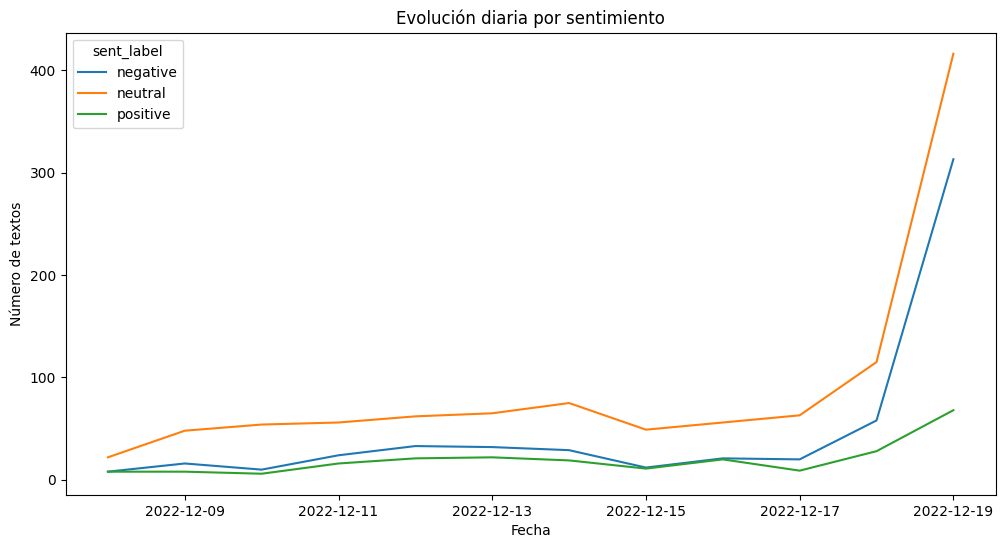

In [23]:
evolucion.plot(kind='line', figsize=(12,6))
plt.title("Evolución diaria por sentimiento")
plt.xlabel("Fecha")
plt.ylabel("Número de textos")
plt.show()


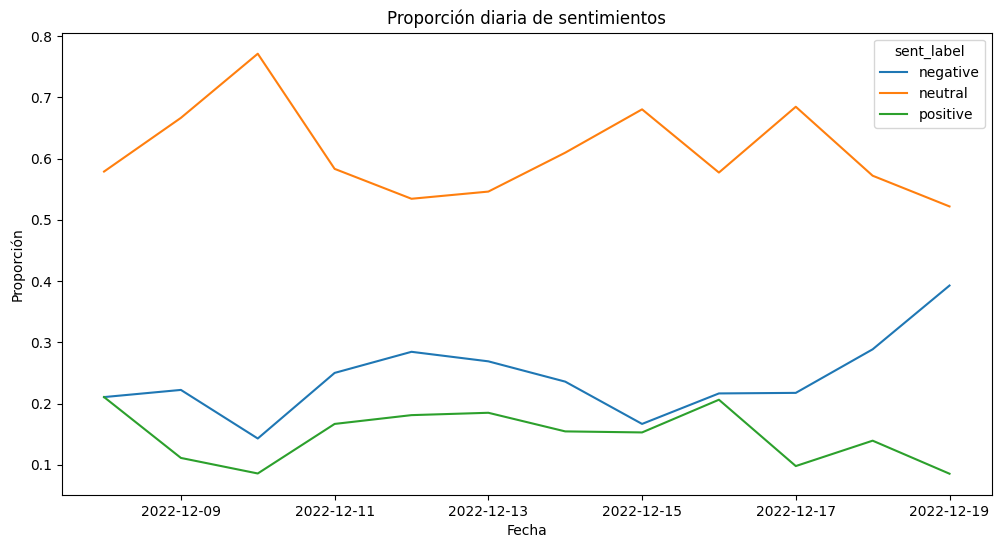

In [24]:
proporciones = evolucion.div(evolucion.sum(axis=1), axis=0)

proporciones.plot(kind="line", figsize=(12,6))
plt.title("Proporción diaria de sentimientos")
plt.xlabel("Fecha")
plt.ylabel("Proporción")
plt.show()
